# Verifying that the matrix DWPC method generates results similar to the Neo4j method

The matrix-based DWPC calculation method does not provide results exactly equal to the Neo4j-based method for all metapaths. We would like to verify that these differences in DWPC calculation do not result in significant differences in the resulting predictions.

In [1]:
import pandas as pd
import matplotlib
import seaborn as sns

In [2]:
%matplotlib inline

---

## Data

Data files are from fold 3 of the full size network (no rare disease data).

In [3]:
orig = pd.read_csv("orig_pred_res_for_roc.tsv", sep='\t')

In [4]:
matx = pd.read_csv("matrix_pred_res_for_roc.tsv", sep='\t')

In [5]:
orig.shape

(14490, 136)

In [6]:
matx.shape

(14490, 107)

In [7]:
orig.head(2)

,compound_id,disease_id,origin,prior_logit,prior_prob,degree_CbG,degree_CcSE,degree_CdG,degree_CiPC,degree_CrC,...,dwpc_CuGdDlAlD,dwpc_CuGuCbGaD,dwpc_CuGuCtD,dwpc_CuGuCtDrD,dwpc_CuGuCuGaD,predicted_value,category,n_curators,n_resources,true_label
0,DB00630,DOID:11476,holdout,-4.052,0.01709,-0.4404,0.06956,0.3272,0.2767,0.4246,...,-0.2499,0.9226,0.1581,-0.3456,0.2536,0.960181,DM,3.0,2.0,1
1,DB00282,DOID:11476,holdout,-3.327,0.03466,-2.0200,0.48600,-0.9726,0.2767,0.4246,...,-0.6252,-0.7182,-0.5078,-0.6414,-0.6768,0.949637,NaN,NaN,NaN,0


In [8]:
matx.head(2)

,chemical_id,disease_id,origin,prior_logit,prior_prob,degree_CbG,degree_CcSE,degree_CdG,degree_CiPC,degree_CrC,...,dwpc_CrCuGiGaD,dwpc_CuGaDuGaD,dwpc_CuGcGiGaD,dwpc_CuGdDlAlD,dwpc_CuGdDpSpD,dwpc_CuGuCtDrD,dwpc_CuGuCuGaD,predicted_value,category,true_label
0,DB00630,DOID:11476,holdout,-4.052,0.01709,-0.4404,0.06956,0.3285,0.2767,0.4246,...,-0.09536,1.5550,0.02598,-0.2318,0.4720,-0.3458,0.2535,0.960243,DM,1
1,DB00282,DOID:11476,holdout,-3.327,0.03466,-2.0200,0.48600,-0.9736,0.2767,0.4246,...,0.52390,-0.6413,-0.58250,-0.6199,-0.6256,-0.6414,-0.6766,0.948716,NaN,0


---

## Check that the pairs are equal

Check that the predictions involve the same chemical-disease pairs.

In [9]:
assert (
    set((r["compound_id"], r["disease_id"]) for i, r in orig.iterrows())
    ==
    set((r["chemical_id"], r["disease_id"]) for i, r in matx.iterrows())
)

---

## Extract out the relevant information

We will exclude the actual DWPC values when comparing the ranks of the predicted results.

In [10]:
tempa = (orig
    [["compound_id", "disease_id", "predicted_value", "true_label"]]
    .rename(columns={
        "compound_id": "chemical_id",
        "predicted_value": "orig_value",
        "true_label": "orig_label"        
    })
)

In [11]:
tempb = (matx
    [["chemical_id", "disease_id", "predicted_value", "true_label"]]
    .rename(columns={
        "predicted_value": "matx_value",
        "true_label": "matx_label"
    })
)

In [12]:
res = tempa.merge(tempb, how="inner", on=["chemical_id", "disease_id"])

In [13]:
res.shape

(14490, 6)

In [14]:
res.head()

,chemical_id,disease_id,orig_value,orig_label,matx_value,matx_label
0,DB00630,DOID:11476,0.960181,1,0.960243,1
1,DB00282,DOID:11476,0.949637,0,0.948716,0
2,DB00884,DOID:5408,0.942462,1,0.945517,1
3,DB00710,DOID:11476,0.918706,1,0.907215,1
4,DB00282,DOID:5408,0.916035,0,0.914161,0


### Check that the true labels are equal

In [15]:
(res["matx_label"] == res["orig_label"]).all()

True

In [16]:
res = (res
    .drop("matx_label", axis=1)
    .rename(columns={"orig_label": "true_label"})
)

In [17]:
res.head()

,chemical_id,disease_id,orig_value,true_label,matx_value
0,DB00630,DOID:11476,0.960181,1,0.960243
1,DB00282,DOID:11476,0.949637,0,0.948716
2,DB00884,DOID:5408,0.942462,1,0.945517
3,DB00710,DOID:11476,0.918706,1,0.907215
4,DB00282,DOID:5408,0.916035,0,0.914161


---

## Calculate the ranks of the predictions

Ranks are assigned in descending order (rank of 1 means the top prediction).

In [18]:
ranks = (res
    .rank(numeric_only=True, ascending=False)
    .drop("true_label", axis=1)
    .rename(columns={
        "orig_value": "orig_rank",
        "matx_value": "matx_rank"
    })
)

In [19]:
ranks.head()

,orig_rank,matx_rank
0,1.0,1.0
1,2.0,2.0
2,3.0,3.0
3,4.0,6.0
4,5.0,4.0


In [20]:
fin = res.merge(ranks, left_index=True, right_index=True)

In [21]:
fin.head()

,chemical_id,disease_id,orig_value,true_label,matx_value,orig_rank,matx_rank
0,DB00630,DOID:11476,0.960181,1,0.960243,1.0,1.0
1,DB00282,DOID:11476,0.949637,0,0.948716,2.0,2.0
2,DB00884,DOID:5408,0.942462,1,0.945517,3.0,3.0
3,DB00710,DOID:11476,0.918706,1,0.907215,4.0,6.0
4,DB00282,DOID:5408,0.916035,0,0.914161,5.0,4.0


---

## Calculate the difference in rank for a prediction between the two methods

Calculate how the ranks differ between the two methods.

In [22]:
fin = (fin
    .assign(
        rank_diff = lambda df: pd.Series.abs(df["orig_rank"] - df["matx_rank"])
    )
    .assign(
        diff_pct = lambda df: df["rank_diff"] / len(fin) * 100
    )
)

In [23]:
fin.head()

,chemical_id,disease_id,orig_value,true_label,matx_value,orig_rank,matx_rank,rank_diff,diff_pct
0,DB00630,DOID:11476,0.960181,1,0.960243,1.0,1.0,0.0,0.000000
1,DB00282,DOID:11476,0.949637,0,0.948716,2.0,2.0,0.0,0.000000
2,DB00884,DOID:5408,0.942462,1,0.945517,3.0,3.0,0.0,0.000000
3,DB00710,DOID:11476,0.918706,1,0.907215,4.0,6.0,2.0,0.013803
4,DB00282,DOID:5408,0.916035,0,0.914161,5.0,4.0,1.0,0.006901


In [24]:
fin["diff_pct"].max()

18.385093167701864

## How much variance in ranking is there?

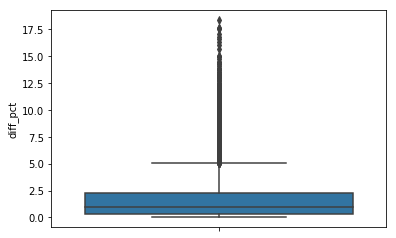

In [25]:
sns.boxplot(y=fin["diff_pct"])

## Does variance vary based on the true label?

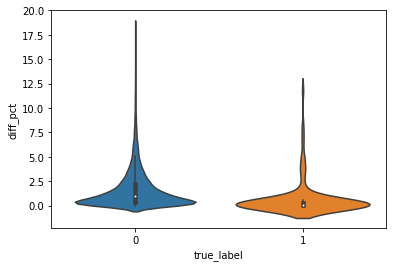

In [26]:
sns.violinplot(data=fin, x="true_label", y="diff_pct")

---

## Visual comparison of ranks

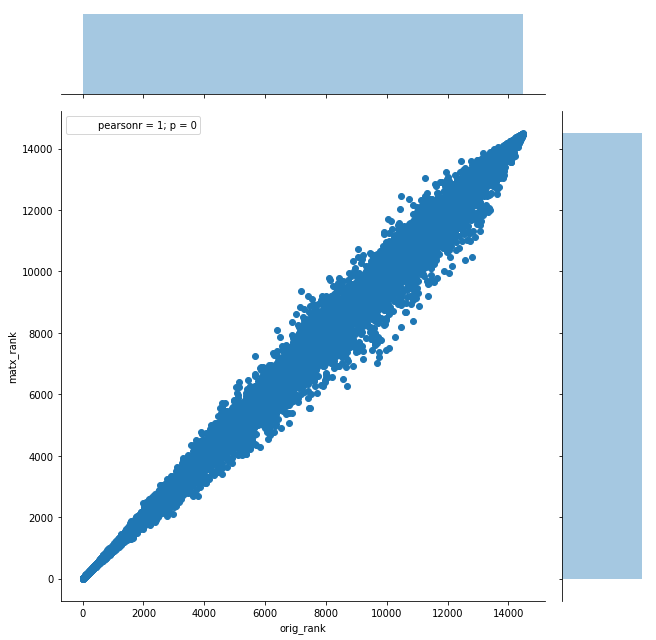

In [27]:
sns.jointplot(
    data=fin,
    x="orig_rank", y="matx_rank",
    size=9
)

For the most part this seems to show that the matrix method is comparable to the original neo4j method at ranking the predictions.

There don't seem to be any major deviations from the y=x line on the predictions. The medium amount of fuzziness is probably due to the fact that the matrix method cannot provide exact matches in DWPC values to the original neo4j method, and therefore this influences the final predicted value, which changes the calculated rank.

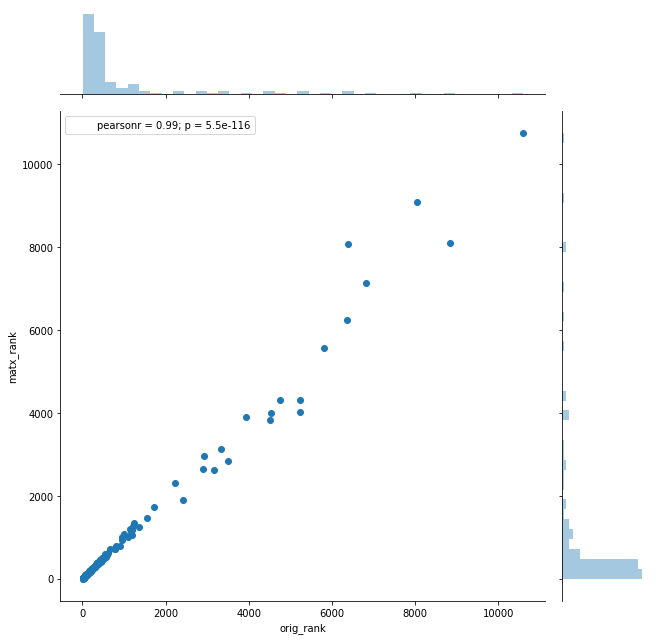

In [28]:
sns.jointplot(
    data=fin.query("true_label == 1"),
    x="orig_rank", y="matx_rank",
    size=9
)

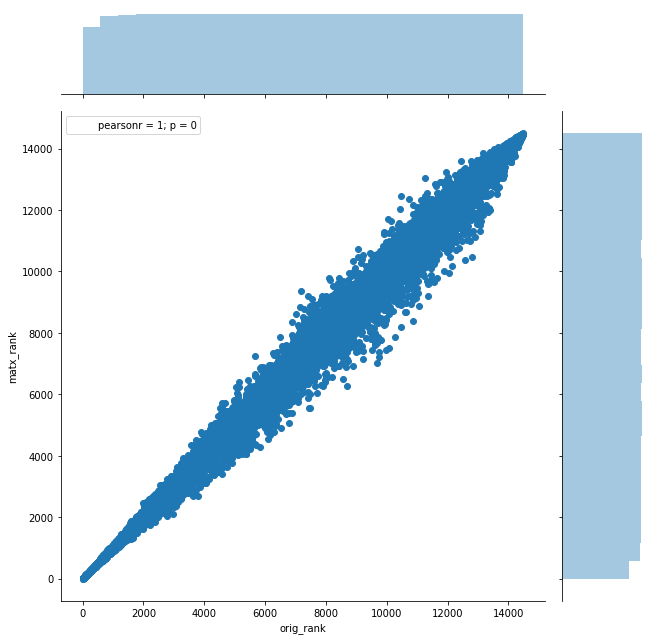

In [29]:
sns.jointplot(
    data=fin.query("true_label == 0"),
    x="orig_rank", y="matx_rank",
    size=9
)

No obvious outliers in the prediction ranks, which implies that the matrix method is generating similar results.

Next: look at the model being built, and the features being selected.